# Preprocessing
### Removing redundant variable 'iso'

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
from sklearn import tree, preprocessing

covid_dataset = pd.read_csv('google_new.csv', na_values=['NA'])

#Searching for null values, none found
print(covid_dataset.isnull().sum())
covid_dataset = covid_dataset[covid_dataset['total_cases'] > 0]
covid_dataset.drop('iso', axis=1, inplace=True)

iso                  0
country              0
date                 0
grocery_pharmacy     0
parks                0
residential          0
retail_recreation    0
transit_stations     0
workplaces           0
total_cases          0
fatalities           0
dtype: int64


### Adding recovered cases and joining provinces to countries

In [2]:
#Recovered cases data retrieved from this repository: https://github.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning)

recv_df = pd.read_csv('time_series_covid19_recovered_global.csv')
   
#Removing column Province/State
recv_df.drop('Province/State', axis=1, inplace=True)

#summing province/state values in only one country
dates = recv_df.columns[4:]
recovered=recv_df.groupby(['Country/Region'], as_index=False)[dates].sum()

#changing the date format of the our data to match the retrieved data 
covid_dataset['date']= pd.to_datetime(covid_dataset.date)
covid_dataset['date'] = covid_dataset['date'].dt.strftime('%m/%d/%Y')

#changing the format of the retrieved dataframe, passing the dates to rows instead of columns, to be able to join with our dataframe
recv_df_long = recovered.melt(id_vars=['Country/Region'],value_vars=dates, var_name='date', value_name='Recovered')
recv_df_long= recv_df_long.rename(columns={'Country/Region': 'country'})
recv_df_long= recv_df_long.rename(columns={'Recovered': 'recovered'})
#Joining the two dataframes

new_covid_dataset = pd.merge(left=covid_dataset, right=recv_df_long, on=['country', 'date']) 
print(new_covid_dataset.loc[:, ['recovered', 'country']])

     recovered       country
0            0     Argentina
1            0     Argentina
2            0     Argentina
3            0     Argentina
4            0     Argentina
..         ...           ...
735         50  South Africa
736         50  South Africa
737         95  South Africa
738         95  South Africa
739         95  South Africa

[740 rows x 2 columns]


### Adding active cases column, and passed days column

In [3]:
#active cases = total confirmed - total recovered - total deaths
new_covid_dataset['active_cases'] = new_covid_dataset['total_cases'] - new_covid_dataset['fatalities'] - new_covid_dataset['recovered']

#converting date string to an actual date
new_covid_dataset['date']= pd.to_datetime(new_covid_dataset.date)

#List of all countries in dataset
countries = new_covid_dataset['country'].unique()

for country in countries:
    country_rows = new_covid_dataset[new_covid_dataset['country'] == country]
    #passed_days is the number of passed days since the first reported day with more than 0 cases
    new_covid_dataset.loc[new_covid_dataset['country'] == country, 'passed_days'] = (country_rows['date'] - country_rows.iloc[0]['date']).dt.days

#removing redundant variable 'date'
new_covid_dataset.drop('date', axis=1, inplace=True)

print(new_covid_dataset.loc[:, ['active_cases', 'passed_days']])

     active_cases  passed_days
0               1          0.0
1               1          1.0
2               1          2.0
3               2          3.0
4               8          4.0
..            ...          ...
735          1325         27.0
736          1407         28.0
737          1401         29.0
738          1481         30.0
739          1549         31.0

[740 rows x 2 columns]


### Adding population and cases per million habitants columns

In [4]:
#dict with populations to fill
population = {'Argentina' : 44490000, 'Australia' : 24990000, 'Brazil' : 209500000,
              'Canada' : 37590000, 'Germany' : 83020000, 'Spain' : 46940000, 
              'France' : 66990000, 'United Kingdom' : 66650000, 'Indonesia' : 267700000, 
              'India' : 1353000000, 'Italy' : 60360000, 'Japan' : 126500000, 
              'South Korea' : 51640000, 'Mexico' : 126200000, 'Saudi Arabia' : 33700000, 
              'Sweden' : 10230000, 'Turkey' : 82000000, 'US' : 328200000, 'South Africa' : 57780000}
for country in countries:
    new_covid_dataset.loc[new_covid_dataset['country'] == country, 'population'] = population[country]
    new_covid_dataset.loc[:, 'cases_per_million'] = new_covid_dataset['active_cases']/(new_covid_dataset['population']/1000000)

print(new_covid_dataset.loc[:, ['population', 'cases_per_million']])
new_covid_dataset.to_csv('result.csv')

     population  cases_per_million
0    44490000.0           0.022477
1    44490000.0           0.022477
2    44490000.0           0.022477
3    44490000.0           0.044954
4    44490000.0           0.179816
..          ...                ...
735  57780000.0          22.931810
736  57780000.0          24.350987
737  57780000.0          24.247144
738  57780000.0          25.631706
739  57780000.0          26.808584

[740 rows x 2 columns]


# Data visualization

### Increase in parks, grocery, transit stations, retil, residential and workplaces visits

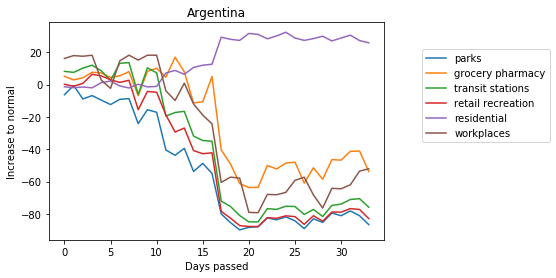

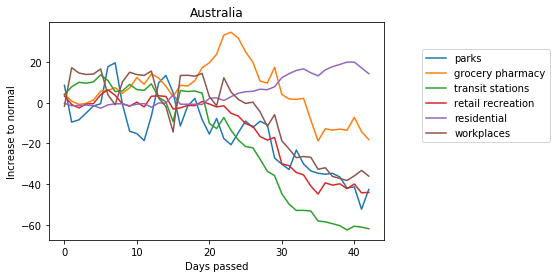

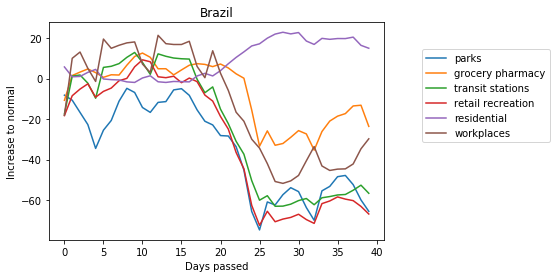

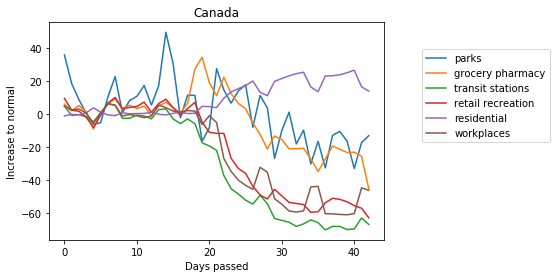

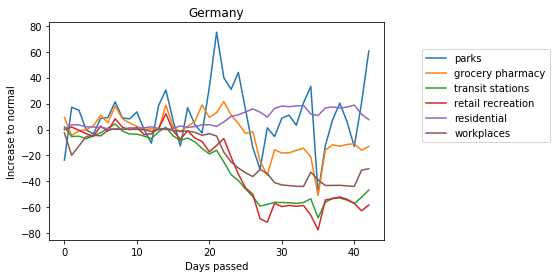

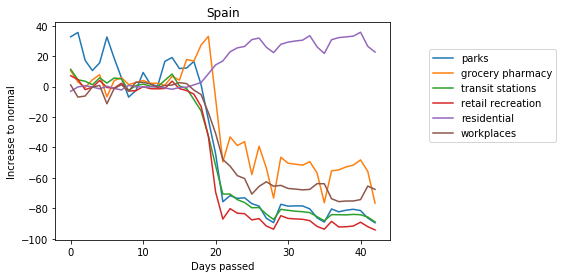

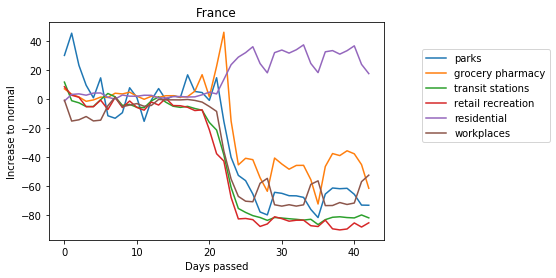

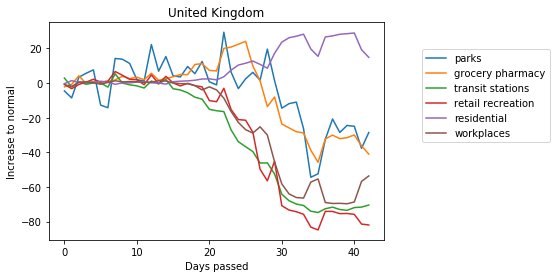

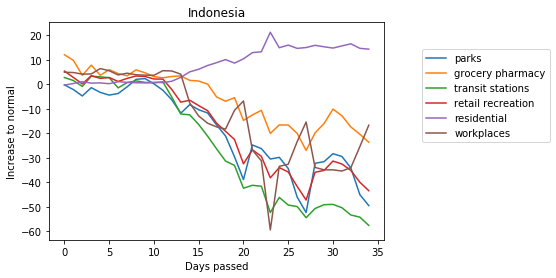

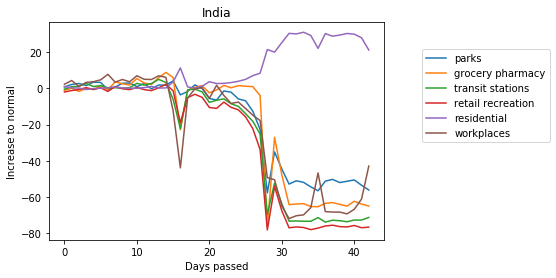

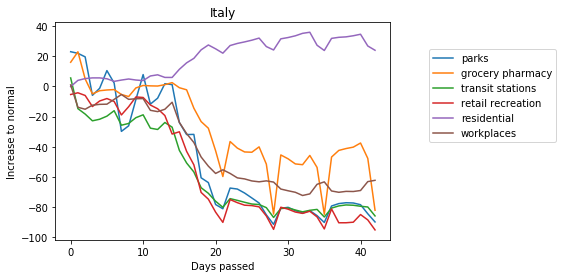

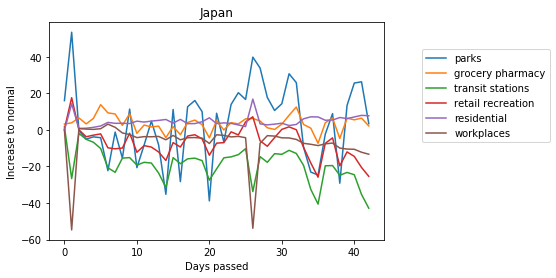

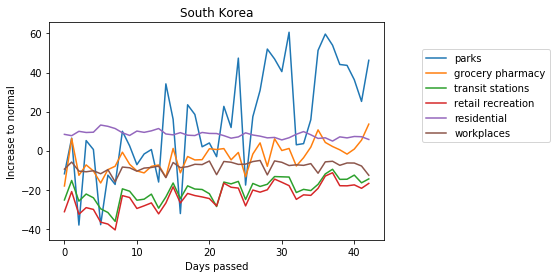

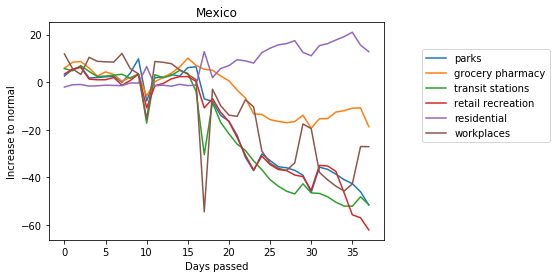

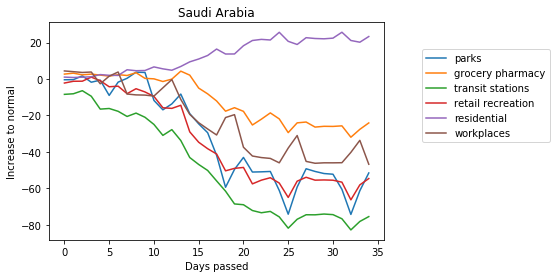

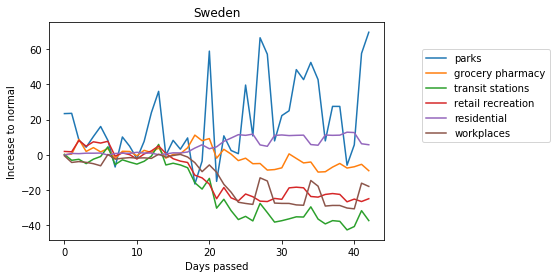

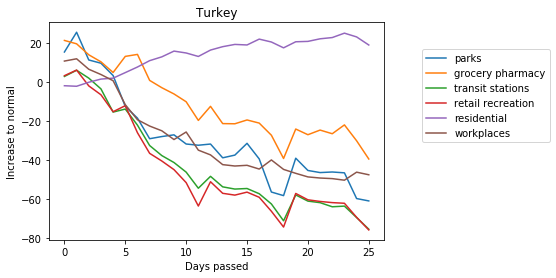

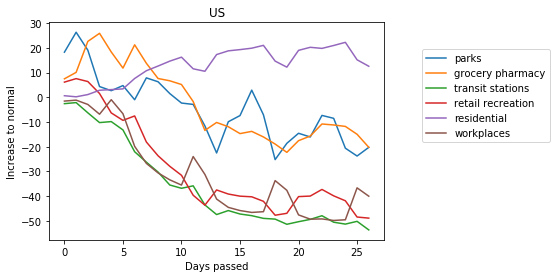

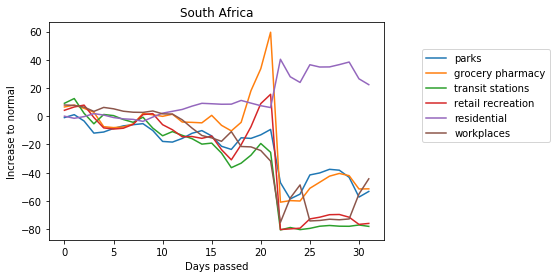

In [5]:
for i in range(0, len(countries)):
    #Rows corresponding to the country in the current iteration
    country_rows = new_covid_dataset[new_covid_dataset['country'] == countries[i]]
    #Plot each of the variables
    plt.plot(country_rows['passed_days'], country_rows['parks'], label='parks')
    plt.plot(country_rows['passed_days'], country_rows['grocery_pharmacy'], label='grocery pharmacy')
    plt.plot(country_rows['passed_days'], country_rows['transit_stations'], label='transit stations')
    plt.plot(country_rows['passed_days'], country_rows['retail_recreation'], label='retail recreation')
    plt.plot(country_rows['passed_days'], country_rows['residential'], label='residential')
    plt.plot(country_rows['passed_days'], country_rows['workplaces'], label='workplaces')
    
    #Title, label and legend
    plt.ylabel('Increase to normal')
    plt.xlabel('Days passed')
    plt.legend(bbox_to_anchor=(1.1, 0.9), loc=2)
    plt.title(countries[i])
    plt.show()

### Nr of cases per country over time

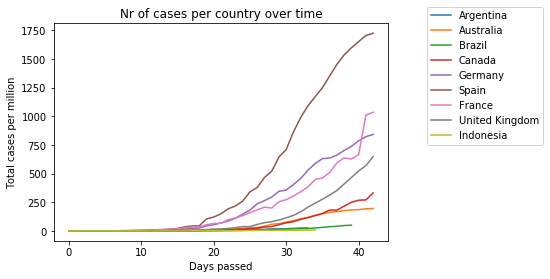

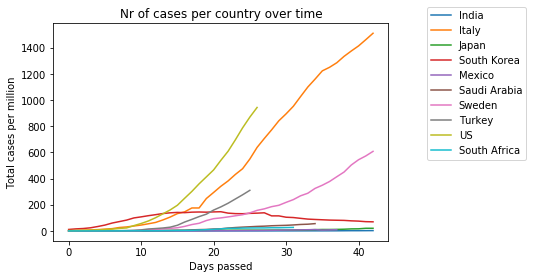

In [6]:
#List of all countries in dataset
countries = covid_dataset['country'].unique()
for i in range(0, (len(countries))//2):
    #Rows corresponding to the country in the current iteration
    country_rows = new_covid_dataset[new_covid_dataset['country'] == countries[i]]
    #Plot total cases
    plt.plot(country_rows['passed_days'], country_rows['cases_per_million'], label=countries[i])
    
#Title, label and legend
plt.ylabel('Total cases per million')
plt.xlabel('Days passed')
plt.legend(bbox_to_anchor=(1.1, 1.1), loc=2)
plt.title('Nr of cases per country over time')
plt.show()

for i in range((len(countries))//2, len(countries)):
    #Rows corresponding to the country in the current iteration
    country_rows = new_covid_dataset[new_covid_dataset['country'] == countries[i]]
    #Plot total cases
    plt.plot(country_rows['passed_days'], country_rows['cases_per_million'], label=countries[i])
    
#Title, label and legend
plt.ylabel('Total cases per million')
plt.xlabel('Days passed')
plt.legend(bbox_to_anchor=(1.1, 1.1), loc=2)
plt.title('Nr of cases per country over time')
plt.show()

# Data prediciton (?)

## Decision Trees

### Preprocessing

In [7]:
le = preprocessing.LabelEncoder()
le.fit(countries)

#DecisionTreeRegressor must take ints/floats, can't take strings, so a dict of name->int is created
countryDict = dict(zip(countries, le.transform(countries)))

inputData = []
outputData = []
for index, row in new_covid_dataset.iterrows():
    inputData.append([
        countryDict[row['country']], row['passed_days']
    ])
    outputData.append([
        float(row['cases_per_million'])
    ])
        
clf = tree.DecisionTreeRegressor()
clf = clf.fit(inputData, outputData)

### Data results

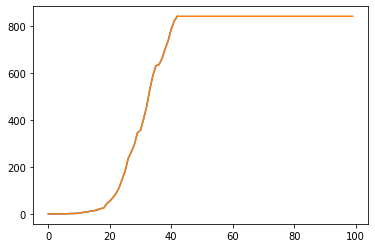

In [8]:
cases = []
passedDays = []
#Temporary, showing prediction for single country
for i in range(100):
    cases.append(clf.predict([[countryDict['Germany'], i]]))
    passedDays.append(i)
    
country_rows = new_covid_dataset[new_covid_dataset['country'] == 'Germany']
#Plot total cases
plt.plot(country_rows['passed_days'], country_rows['cases_per_million'])
plt.plot(passedDays, cases)
plt.show()

In [37]:
new_covid_dataset['cases_last_day'] = new_covid_dataset['total_cases'].shift(1) - new_covid_dataset['total_cases'].shift(2) 
new_covid_dataset['cases_last_day'].fillna(0, inplace=True)
print(new_covid_dataset['cases_last_day'])

#new_covid_dataset['cases_last_day'] = new_covid_dataset['cases_per_million'].shift(1) - new_covid_dataset['cases_per_million'].shift(2) 
#new_covid_dataset['cases_last_day'].fillna(0, inplace=True)

      country  grocery_pharmacy   parks  residential  retail_recreation  \
0   Argentina             5.090  -6.241       -1.330              0.200   
1   Argentina             2.898  -0.579       -1.916             -0.983   
2   Argentina             4.236  -8.884       -1.491              0.735   
3   Argentina             7.630  -6.797       -1.996              6.376   
4   Argentina             7.222  -9.604        1.219              5.391   
5   Argentina             4.425 -12.354        2.186              3.013   
6   Argentina             5.438  -9.125       -0.813              1.373   
7   Argentina             8.046  -8.646       -2.092              2.687   
8   Argentina            -6.831 -24.127        0.207            -15.515   
9   Argentina             8.224 -15.550       -1.410             -4.239   
10  Argentina            10.128 -17.125       -1.125             -4.731   
11  Argentina             4.578 -40.463        7.188            -18.762   
12  Argentina            